In [11]:
# This file is aimed to add Xe to the model and see if the model can be improved
from src.DataPrepocessing import *
from src.NeuralNets import *
from src.TrainMethod import *

import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [12]:
sequence_length = 10
batch_size = 16
# num = 4


test_file_name = f'HxF_three.csv'
train_file_name = f'HxF_three.csv'

# test_file_name = 'Gamma_Final_quantile_1.csv'
# train_file_name = 'Gamma_Final_quantile_1.csv'

# test_file_name = "Cs_Xe_shuffle_training.csv"
# train_file_name = "Cs_Xe_shuffle_testing.csv"
model_name = f'HxF_three'


train_folds = 7
test_folds = 3

# Read the data and do the standarlize

In [13]:
origin_data = np.loadtxt(f'./Processed Data/{train_file_name}', delimiter= ',', dtype= np.float64)
ss = StandardScaler()
data = ss.fit_transform(origin_data)
data.shape

(1357, 322)

In [14]:
# def K_Fold(data, folds_num, train_num):
import random

split_parts = np.array_split(data, train_folds + test_folds)
random.shuffle(split_parts)


training_raw_data = np.vstack(split_parts[:train_folds])
testing_raw_data = np.vstack(split_parts[train_folds:])

print("Training data shape:" ,training_raw_data.shape)
print("Testing data shape: ",testing_raw_data.shape)
    

Training data shape: (950, 322)
Testing data shape:  (407, 322)


In [27]:
# define the training and testing set
training_data = ReactorData(training_raw_data,sequence_length,0,1)
testing_data = ReactorData(testing_raw_data,sequence_length,0,1)
all_data = ReactorData(data,sequence_length,0,1)


# Training

In [16]:
# define neural nets
import json

input_dim = training_data[0][0].shape[1]



# print(output_dim)

# some adjustable hyper-parameters
nets_hyper_parameters = {
'input_dim' : input_dim,
'output_dim' : 1,
'hidden_dim' : 256,
'lstm_nums_layer' : 2,
'dropout' : 0.2 
}

nets_hyper_parameters = {
'input_dim' : input_dim,
'output_dim' : 1,
'hidden_dim' : 256,
'dropout' : 0.2 
}

# save the hyper params as json

def write_dict_to_json(data, file_path):
    with open(file_path, 'w') as json_file:
        json.dump(data, json_file)

write_dict_to_json(nets_hyper_parameters, f"./Model_params/{model_name}")


model = SimpleLSTM(**nets_hyper_parameters)


In [17]:
model.parameters

<bound method Module.parameters of SimpleLSTM(
  (LSTM): LSTM(321, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (hidden_to_output): Linear(in_features=256, out_features=1, bias=True)
)>

In [18]:
optimizer_parameters = {
    'params':model.parameters(),
    'lr' : 0.005,
    'weight_decay' : 0.005
}


train_parameters = {
    'model' : model,
    'training_data' : training_data,
    'epoch_num': 100,
    'batch_size': batch_size,
    'optimizer' : optim.Adam(**optimizer_parameters),
    'loss_fn' : nn.MSELoss(),
    'print_out_frequency': 20,
    'shuffle': True,

}


model, _ = train(** train_parameters)

The loss is 0.24873878067840033 in epoch 0
The loss is 0.07399142907530193 in epoch 20
The loss is 0.08574769402743544 in epoch 40
The loss is 0.08391774659231623 in epoch 60
The loss is 0.06133566686632605 in epoch 80
Training is finished, the final loss is 0.057669353130836945


In [19]:
# save the model for future use
torch.save(model.state_dict(), f"./Model/{model_name}")

# Visualization

In [20]:
model = SimpleLSTM(**nets_hyper_parameters)
model.load_state_dict(torch.load(f"./Model/{model_name}"))  # 加载模型权重
model.eval() 

SimpleLSTM(
  (LSTM): LSTM(321, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (hidden_to_output): Linear(in_features=256, out_features=1, bias=True)
)

In [21]:
# this function is written by chatgpt. Many thanks to him!

import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def eval(data, batch_size, sequence_length):
    # Assuming you have a DataSet object called 'training_data' and a trained model called 'model'
    training_set = data
    # Step 1: Create a DataLoader from your DataSet object
    batch_size = batch_size  # Adjust this value based on your model's input requirements
    train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=False)

    # Step 2 & 3: Iterate through the DataLoader and collect predictions and true labels
    predictions = []
    true_labels = []

    sequence_length = sequence_length  # Assuming a sequence length of 10

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in train_loader:
            # Pass the input data to the trained model and collect the predictions
            preds = model(inputs)
            preds = preds.reshape(-1, sequence_length)  # Reshape the predictions to (batch_size, sequence_length, output_dim)
            predictions.extend(preds.squeeze().view(-1).tolist())  # Flatten the predictions
            true_labels.extend(labels.squeeze().view(-1).tolist())  # Flatten the true labels

    # Step 4: Plot the predictions and true labels for comparison
    loss = nn.MSELoss()
    tensor1 = torch.tensor(predictions)
    tensor2 = torch.tensor(true_labels)
    test_loss = loss(tensor1, tensor2)
    # print(test_loss)

    plt.figure()
    plt.title(model_name)
    plt.xlabel('Timestamp')
    plt.ylabel('Keff')
    plt.plot(true_labels, label="Real")
    plt.plot(predictions, label="Predict", alpha = 0.7)
    plt.legend()
    plt.show()

    return np.array(true_labels), np.array(predictions)


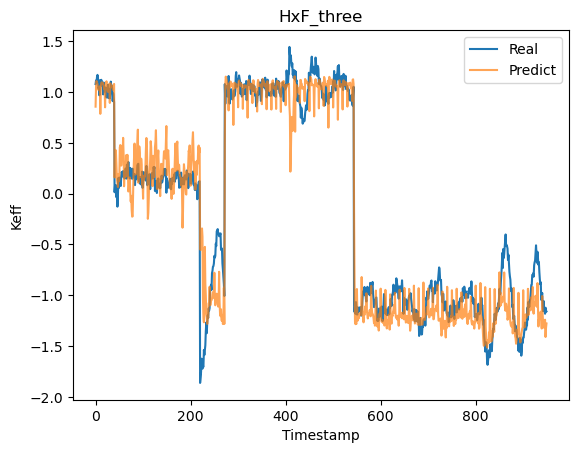

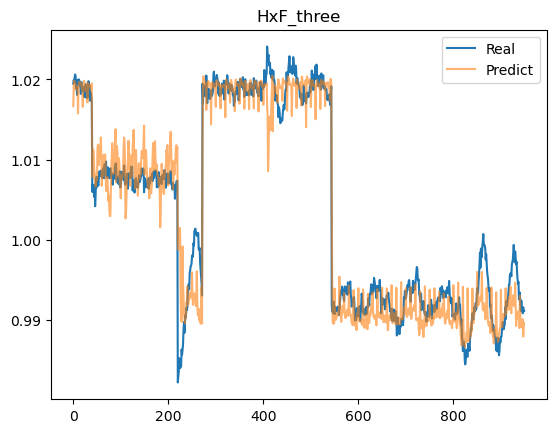

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# 在这里设置 train_test_split 的值
all_labels, predictions =  eval(training_data, batch_size, sequence_length)
# change to the original unit
true_labels = all_labels
predictions = predictions
X = training_data.unshaped_data




result_y = np.append(true_labels.reshape(-1,1),X, axis=1)
result_predict = np.append(predictions.reshape(-1,1),X,  axis=1)

y = ss.inverse_transform(result_y)
predict = ss.inverse_transform(result_predict)



# plt.ylim((0.8,1.1))
# plt.plot(y[:,1]/max(y[:,1]), label = "power")
# plt.plot(y[:,2]/max(y[:,2]), label = "thre")
plt.plot(y[:,0], label = "Real")     
plt.plot(predict[:,0], label = "Predict", alpha=0.6)
plt.title(model_name)
plt.legend()

# 显示图形
plt.show()




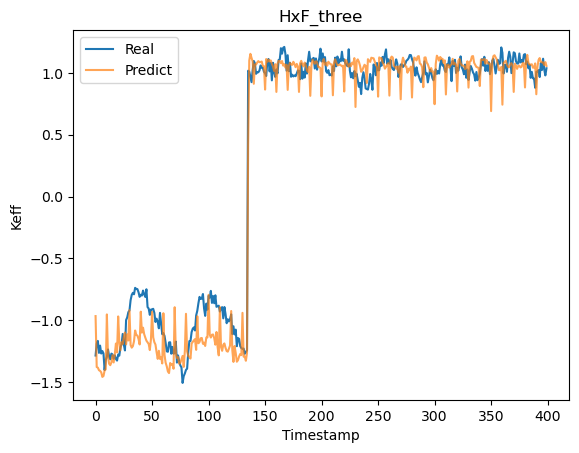

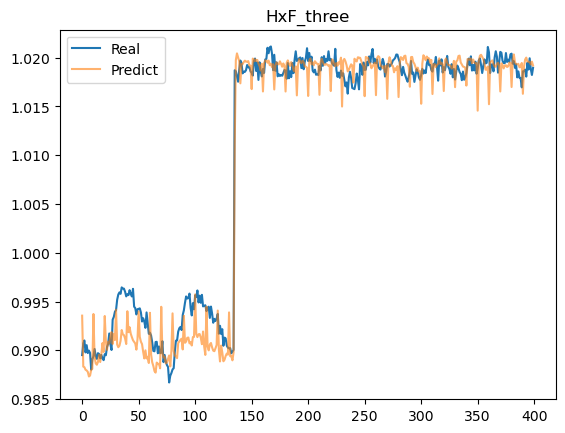

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# 在这里设置 train_test_split 的值
all_labels, predictions =  eval(testing_data, batch_size, sequence_length)
# change to the original unit
true_labels = all_labels
predictions = predictions
X = testing_data.unshaped_data




result_y = np.append(true_labels.reshape(-1,1),X, axis=1)
result_predict = np.append(predictions.reshape(-1,1),X,  axis=1)

y = ss.inverse_transform(result_y)
predict = ss.inverse_transform(result_predict)



# plt.ylim((0.8,1.1))
# plt.plot(y[:,1]/max(y[:,1]), label = "power")
# plt.plot(y[:,2]/max(y[:,2]), label = "thre")
plt.plot(y[:,0], label = "Real")     
plt.plot(predict[:,0], label = "Predict", alpha=0.6)
plt.title(model_name)
plt.legend()

# 显示图形
plt.show()




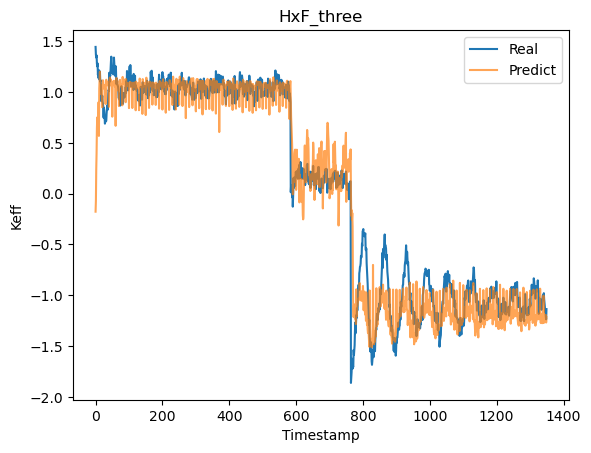

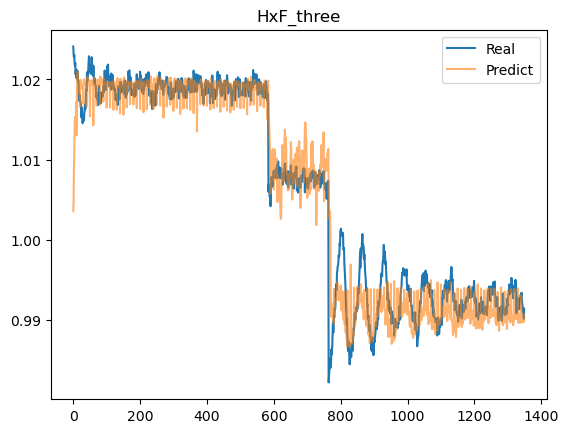

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# 在这里设置 train_test_split 的值
all_labels, predictions = eval(all_data, batch_size, sequence_length)
# change to the original unit
true_labels = all_labels
predictions = predictions
X = all_data.unshaped_data




result_y = np.append(true_labels.reshape(-1,1),X, axis=1)
result_predict = np.append(predictions.reshape(-1,1),X,  axis=1)

y = ss.inverse_transform(result_y)
predict = ss.inverse_transform(result_predict)



# plt.ylim((0.8,1.1))
# plt.plot(y[:,1]/max(y[:,1]), label = "power")
# plt.plot(y[:,2]/max(y[:,2]), label = "thre")
plt.plot(y[:,0], label = "Real")     
plt.plot(predict[:,0], label = "Predict", alpha=0.6)
plt.title(model_name)
plt.legend()

# 显示图形
plt.show()


